## Generation of main graph dictionary and various specific data frames 

This notebook is the main notebook for generating the graphs and metrics from the raw connectome files, it produces 
and saves (pickles) ' graph_dict ' which includes a dictionary for each subject (run) which contains the data itself, the graph generated from networkx, various global metrics and dictionaries of various node based measures. The intent is to use this graph dicionary as the main data source of analysis - other data frames and dictionaries are then to be created from this. This should involve as many computationally expensive steps as possible to avoid them later.

Ideally I will then convert into a proper script and break up into functions but right now I am focused on getting usable code for analysis on the smaller multi run data 

For now it is organised as follows - 
1) an introductory cell to import and set various lists and variables to point to strings that will be dictionary keys

2) a main loop that creates and fills the graph dict with the various metrics (this isn't set in stone, more metrics wwill be added, some will be discarded

3) a cell to re-structure the dictionary labels for node based measures to be more human readable, and less prone to mistakes when converting and working with data as a matrix

4) cells to pickle and unpickle the main dictionary

5) a few cells to generate node feature data frames that are suitable to be saved as csv to be easier to call in analysis 

6) a couple of measures like degree hist and laplacian spectrum which I havent decided how to save and use yet

Note the structure is in (Subject)(run) this can cause confusion and conflict - however it is currently the most flexible way (I can think of) to organise as I am still analysisng the effects of rerunning tractography, it should be fairly simple to adapt the code to either not include (run) or standadise one run - the former is likely to be how I handle it once we have decided on a way forward with consistent tractography. 

In [2]:
# this cell imports the necessary packages - sets variables to point to string keys - sets the sub case and control
# dictionaries as well as creating lists of global node and othe metrics


import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle

# set variables that will point to dictionary keys - with the type/output will be in the dict, note these 
# are not based on the output of the analagous networkx function but how I have written into dict


#data/matrices
graph = "graph" #networkx graph basically dictionaries all the way down
data = "data" #pandas data frame 
bin_mat = "binary_matrix" #numpy array 
bin_df = "binary_df"
data_numpy = "data_as_numpy_array" #numpy array
norm_lap = "normalised_laplacian" #numpy array?

#global metrics 
gl_eff = "global_efficiency" #float
loc_eff = "local_efficiency" #float
clus_coef = "clusetering_coefficent" #float
ave_path_length = "ave_path_length" #float
clique_num = "clique_number" #int (poss float but always integer valued)
ass_coef = "assortativity_coefficient" #float
transitivity = "transitivity" #float
rich_club_coeff = "rich_club_coefficient" #currently not working would be float
sw_sigma = "" #currently not working would be float
sw_gamma = "" #currently not working would be float
ave_strength = "average_node_strength" #float
no_edges = "number_of_edges" #int
ave_deg = "average_degree" #int

#individual node/edge metrics and dicts
deg = "degree" #dictionary - nodes as key degree as values 
bet_cent = "betweenness_centrality" # dictionary - nodes as key betweeness as values 
edge_bet_cent = "edge_betweenness_centrality" # dictionary - edge tuple as key edgebetweeness centrality as values 
eigen_cent = "eigenvector_centrality" # dictionary - nodes as eigenvalue centrality as values 
deg_cent = "degree_centrality" # dictionary - nodes as key degree centrality as values 
strength = "node_strength"  # dictionary - nodes as key strength as values 

#other
deg_hist = "degree_histogram" #list - index is degree value is how many nodes with that degree 
norm_lap_spec = "normalised_laplacian_spectrum" #list of floats?


#subject dictionary with a list of runs - corresponds to how connectome file is saved for now hand written 
sub_dict = {"NENAH004" : ["orig", "run2"], "NENAH010" :  ["orig", "run2"], "NENAH011" :  ["orig", "run2"],
                "NENAH012" : ["orig", "run2"], "NENAH015" : ["orig", "run2"], "NENAH016" : ["orig", "run2"], 
                "NENAH022" : ["orig", "run2"], "NENAH024" : ["orig", "run2"], "NENAHC002" : ["orig", "run2", "run3"], 
                "NENAHC003" : ["orig", "run2","run3"], "NENAHC010" : ["orig", "run2", "run3"],
                "NENAHC013" : ["orig", "run2", "run3"], "NENAHC016" : ["orig", "run2", "run3"],
                "NENAHC018" : ["orig", "run2", "run3"], "NENAHC020": ["orig", "run2", "run3"],
                "NENAHC025" : ["orig", "run2"]
           }

case_dict = {"NENAH004" : ["orig", "run2"], "NENAH010" :  ["orig", "run2"], "NENAH011" :  ["orig", "run2"],
                "NENAH012" : ["orig", "run2"], "NENAH015" : ["orig", "run2"], "NENAH016" : ["orig", "run2"], 
                "NENAH022" : ["orig", "run2"], "NENAH024" : ["orig", "run2"]
            }

control_dict = { "NENAHC002" : ["orig", "run2", "run3"],  "NENAHC003" : ["orig", "run2", "run3"], 
                "NENAHC010" : ["orig", "run2", "run3"],"NENAHC013" : ["orig", "run2", "run3"],
                "NENAHC016" : ["orig", "run2", "run3"], "NENAHC018" : ["orig", "run2", "run3"],
                "NENAHC020": ["orig", "run2", "run3"], "NENAHC025" : ["orig", "run2",]
             }

#create the lists which might be usuefull in automating data frame creation
#note these should be strings
global_metrics = [gl_eff, loc_eff, clus_coef, ave_path_length, clique_num,
                  transitivity, ave_strength, no_edges, ave_deg] 

node_metrics = [deg, strength, bet_cent, eigen_cent, deg_cent]

other_metrics = [deg_hist, norm_lap_spec, edge_bet_cent,]




Note: I may need to change the main loop below to reflect how I have now made comp_dict, ie include residules and weighted and binary outputs at thresholds - however that will involve non-trivial looping

### this cell is the main gerative loop - generating main dict that all other data frames can be generated from

In [ ]:
# this cell is the main gerative loop - generating main dict that all other data frames
# can be generated from


#to test main loop 
# sub_dict = {"NENAH004" : ["orig", "run2"], "NENAHC018" : ["orig", "run2", "run3"] }

#initialise the main dictionary of the graphs - this will be pickled saved and used to create lots of different 
#data frames and various things,
graph_dict={}

# initialise various input parameters for main functions - these are tempoary depending on how analysis goes 
binary_thresholds = [0, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
#note 0.0001 was first order of magnitude to display difference, 0.1 was too high to be meaningful, 
# havent tried non powers of 10 yet 

#main loop - loops over subjects and then runs according to the dictionary, and then loops over runs
# for for each run a dictionary is created with the various metrics graphs and related data
# this is using a file structure not like bids atm but was easier for me to set up - all conncectomes are labelled
# by sub idea in one folder - this will be changed into a raw data folder or to use the bids data structure for now 
# I will keep it like this as it is still clear and usable
for sub in sub_dict :
    file ="_10M_sift__Connectome_"
    for run in sub_dict[sub] :
#         print(run)
        #initialise the dictionary for this subjects specific run of tractography
        graph_dict[f'{sub}{run}']={}
        print(f'{sub}{file}{run}.csv')
        
#         load in data for subjectrun and create the grapj 
        df = pd.read_csv(f'{sub}{file}{run}.csv', header=None)
        G = nx.from_pandas_adjacency(df)

    # add these into subjectrun dictionary
    
        graph_dict[f'{sub}{run}']["graph"] = G
        graph_dict[f'{sub}{run}']["data"] = df
        graph_dict[f'{sub}{run}'][data_numpy] = pd.DataFrame.to_numpy(df)
           # this runs through the numpy array checking if the value is above binary threshold - assigning one if true 0 if not
            
# calculate and add to dictionary various graph mesures, the majority are basic networkx functions some I 
# have modified and some I need to change and rework to get functional    
        graph_dict[f'{sub}{run}'][no_edges] = nx.number_of_edges(G)
        graph_dict[f'{sub}{run}'][deg] = dict(nx.degree(G))
        graph_dict[f'{sub}{run}'][ave_deg] = sum(graph_dict[f'{sub}{run}'][deg].values()) / (len(graph_dict[f'{sub}{run}'][graph]))
        graph_dict[f'{sub}{run}'][strength] = dict(nx.degree(G, weight="weight"))
        graph_dict[f'{sub}{run}'][ave_strength] = sum(graph_dict[f'{sub}{run}'][strength].values()) / (len(graph_dict[f'{sub}{run}'][graph]))
        graph_dict[f'{sub}{run}'][gl_eff] = nx.global_efficiency(G)
        graph_dict[f'{sub}{run}'][loc_eff] = nx.local_efficiency(G)
        graph_dict[f'{sub}{run}'][clus_coef] = nx.average_clustering(G)
        graph_dict[f'{sub}{run}'][ave_path_length] = nx.average_shortest_path_length(G)
        graph_dict[f'{sub}{run}'][clique_num] = nx.graph_clique_number(G)
        graph_dict[f'{sub}{run}'][transitivity] = nx.transitivity(G)
        graph_dict[f'{sub}{run}'][norm_lap] = nx.normalized_laplacian_matrix(G).toarray()
        graph_dict[f'{sub}{run}'][norm_lap_spec] = nx.normalized_laplacian_spectrum(G)
        graph_dict[f'{sub}{run}'][deg_hist] = nx.degree_histogram(G)
        graph_dict[f'{sub}{run}'][bet_cent] = nx.betweenness_centrality(G)
        graph_dict[f'{sub}{run}'][edge_bet_cent] = nx.edge_betweenness_centrality(G)
        graph_dict[f'{sub}{run}'][eigen_cent] = nx.eigenvector_centrality_numpy(G, weight="weight")
        graph_dict[f'{sub}{run}'][deg_cent] = nx.degree_centrality(G)
        for threshold in binary_thresholds :
            graph_dict[f'{sub}{run}'][bin_mat +f'_{str(threshold)}'] = (graph_dict[f'{sub}{run}'][data_numpy] > threshold).astype(np.int_)
            graph_dict[f'{sub}{run}'][bin_df +f'_{str(threshold)}'] = (graph_dict[f'{sub}{run}'][data] > threshold).astype(np.int_)
#         graph_dict[f'{sub}{run}'][rich_club_coeff] = nx.rich_club_coefficient(G) - cant get this to wor
#         graph_dict[f'{sub}{run}'][ass_coef] = \
#         graph_dict[f'{sub}{run}'][small world omega]
#         graph_dict[f'{sub}{run}'][small world sigma]
#         print(f'{sub}{run}')
#         print(graph_dict[f'{sub}{run}'][norm_lap])

# to add - fixed rich and small - degree sequence manually deg_hist awkward - strength distribution?



I then as a check see which keys have been created for a subject - note the current name structure being 'subrun'
It is worth using this cell to inspect some values as well 

In [ ]:
graph_dict["NENAH004orig"].keys()

This next cell relables all the 'node metrics' dictionaries to have keys of 'node x' instead of simply 'x' this reads better 
both when presented as tables and will avoid potentially missing conversion errors as will no longer just be a number
which may have not been converted to various matrices correctly 

In [ ]:
# re label node attribute keys as "node x" instead of x

for sub in sub_dict :
    for run in sub_dict[sub] :
        for met in node_metrics :
            for i in range(len(graph_dict[f'{sub}{run}'][met])):
                graph_dict[f'{sub}{run}'][met]["node " + str(i)] = graph_dict[f'{sub}{run}'][met].pop(i)
                
                
# check relabel as expected on a particular metric 
# print(graph_dict["NENAH004orig"][strength])

###### The next cell pickles and saves the main graph_dict,
###### The one after loads the file 'graph_dict.pickle' which should be in the expected format and is assigned as 'graph_dict' this is for testing later steps without having to re-generate the whole graph_dict 

In [60]:
# pickle and save the main graph dict generated abbove - note pickle is not secure so may have to think
# of alternative ways of storing the graphs and complicated structures along with subjects and run info

with open('graph_dict.pickle', 'wb') as handle:
    pickle.dump(graph_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [3]:
# load (unpickle the graph _dict) - note pickle is not secure so may have to think
# of alternative ways of storing the graphs and complicated structures along with subjects and run info

with open('graph_dict.pickle', 'rb') as handle:
     graph_dict = pickle.load(handle)

In [61]:
# the next few cells are used to create and save node based measures into sepreate dict and df

# degree - first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}

#for test loop only


deg_dict = {}
for sub in sub_dict:
    for run in sub_dict[sub]:
        deg_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg]

deg_df = pd.DataFrame.from_dict(deg_dict, orient="index")
deg_df.index.name = "sub-id"
deg_df.to_csv(f'{deg}.csv')

# print(deg_dict)

# initialise and fill dictionary with degree dict for each subject
deg_case_dict = {}
for sub in case_dict:
    for run in case_dict[sub]:
        deg_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg]

# create and save data ftame
deg_case_df = pd.DataFrame.from_dict(deg_case_dict, orient="index")
deg_case_df.index.name = "sub-id"
deg_case_df.to_csv(f'{deg}_case.csv')


deg_control_dict = {}
for sub in control_dict:
    for run in control_dict[sub]:
        deg_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg]


deg_control_df = pd.DataFrame.from_dict(deg_control_dict, orient="index")
deg_control_df.index.name = "sub-id"
deg_control_df.to_csv(f'{deg}_control.csv')


# print(deg_control_dict)




In [62]:
#node strength
#  first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}



strength_dict ={}
for sub in sub_dict :
    for run in sub_dict[sub] :
        strength_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][strength] 

strength_df = pd.DataFrame.from_dict(strength_dict, orient = "index")
strength_df.index.name = "sub-id"
strength_df.to_csv(f'{strength}.csv')

strength_case_dict = {}
for sub in case_dict:
    for run in case_dict[sub]:
        strength_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][strength]


strength_case_df = pd.DataFrame.from_dict(strength_case_dict, orient="index")
strength_case_df.index.name = "sub-id"
strength_case_df.to_csv(f'{strength}_case.csv')


strength_control_dict = {}
for sub in control_dict:
    for run in control_dict[sub]:
        strength_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][strength]

strength_control_df = pd.DataFrame.from_dict(strength_control_dict, orient="index")
strength_control_df.index.name = "sub-id"
strength_control_df.to_csv(f'{strength}_control.csv')

In [63]:
# edge betweeness centrality 
# first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}


edge_bet_cent_dict ={}
for sub in sub_dict :
    for run in sub_dict[sub] :
        edge_bet_cent_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][edge_bet_cent] 

            
edge_bet_cent_df = pd.DataFrame.from_dict(edge_bet_cent_dict, orient = "index")
edge_bet_cent_df.index.name = "sub-id"
edge_bet_cent_df.to_csv(f'{edge_bet_cent}.csv')

edge_bet_cent_case_dict = {}
for sub in case_dict:
    for run in case_dict[sub]:
        edge_bet_cent_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][edge_bet_cent]

edge_bet_cent_case_df = pd.DataFrame.from_dict(edge_bet_cent_case_dict, orient="index")
edge_bet_cent_case_df.index.name = "sub-id"
edge_bet_cent_case_df.to_csv(f'{edge_bet_cent}_case.csv')

edge_bet_cent_control_dict = {}
for sub in control_dict:
    for run in control_dict[sub]:
        edge_bet_cent_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][edge_bet_cent]

edge_bet_cent_control_df = pd.DataFrame.from_dict(edge_bet_cent_dict, orient="index")
edge_bet_cent_control_df.index.name = "sub-id"
edge_bet_cent_control_df.to_csv(f'{edge_bet_cent}_control.csv')

In [64]:
#betweeness centrality
# first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}

# note only re label keys on first loop as the subsequent loops take from this key changed dict

bet_cent_dict ={}
for sub in sub_dict :
    for run in sub_dict[sub] :
        bet_cent_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][bet_cent] 

            
bet_cent_df = pd.DataFrame.from_dict(bet_cent_dict, orient = "index")
bet_cent_df.index.name = "sub-id"
bet_cent_df.to_csv(f'{bet_cent}.csv')

bet_cent_case_dict = {}
for sub in case_dict:
    for run in case_dict[sub]:
        bet_cent_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][bet_cent]

bet_cent_case_df = pd.DataFrame.from_dict(bet_cent_case_dict, orient="index")
bet_cent_case_df.index.name = "sub-id"
bet_cent_case_df.to_csv(f'{bet_cent}_case.csv')

bet_cent_control_dict = {}
for sub in control_dict:
    for run in control_dict[sub]:
        bet_cent_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][bet_cent]

bet_cent_control_df = pd.DataFrame.from_dict(bet_cent_control_dict, orient="index")
bet_cent_control_df.index.name = "sub-id"
bet_cent_control_df.to_csv(f'{bet_cent}_control.csv')

In [65]:
#eigenvector centrality 
# first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}


eigen_cent_dict ={}
for sub in sub_dict :
    for run in sub_dict[sub] :
        eigen_cent_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][eigen_cent] 


eigen_cent_df = pd.DataFrame.from_dict(eigen_cent_dict, orient = "index")
eigen_cent_df.index.name = "sub-id"
eigen_cent_df.to_csv(f'{eigen_cent}.csv')

eigen_cent_case_dict ={}
for sub in case_dict :
    for run in case_dict[sub] :
        eigen_cent_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][eigen_cent] 


eigen_cent_case_df = pd.DataFrame.from_dict(eigen_cent_case_dict, orient = "index")
eigen_cent_case_df.index.name = "sub-id"
eigen_cent_case_df.to_csv(f'{eigen_cent}_case.csv')

eigen_cent_control_dict ={}
for sub in control_dict :
    for run in control_dict[sub] :
        eigen_cent_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][eigen_cent] 


eigen_cent_control_df = pd.DataFrame.from_dict(eigen_cent_control_dict, orient = "index")
eigen_cent_control_df.index.name = "sub-id"
eigen_cent_control_df.to_csv(f'{eigen_cent}_control.csv')


In [66]:
# degree centrality
# first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}

deg_cent_dict ={}
for sub in sub_dict :
    for run in sub_dict[sub] :
        deg_cent_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg_cent]
            
deg_cent_df = pd.DataFrame.from_dict(deg_cent_dict, orient = "index")
deg_cent_df.index.name = "sub-id"
deg_cent_df.to_csv(f'{deg_cent}.csv')

deg_cent_case_dict ={}
for sub in case_dict :
    for run in case_dict[sub] :
        deg_cent_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg_cent] 
            
deg_cent_case_df = pd.DataFrame.from_dict(deg_cent_case_dict, orient = "index")
deg_cent_case_df.index.name = "sub-id"
deg_cent_case_df.to_csv(f'{deg_cent}_case.csv')

deg_cent_control_dict ={}
for sub in control_dict :
    for run in control_dict[sub] :
        deg_cent_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg_cent] 
            
deg_cent_control_df = pd.DataFrame.from_dict(deg_cent_control_dict, orient = "index")
deg_cent_control_df.index.name = "sub-id"
deg_cent_control_df.to_csv(f'{deg_cent}_control.csv')

In [67]:
#produce and save data frame of global metrics and seperate case and controls
# first loop creates data frame and saves for all subjects, the second
# for only case subjects from case_dict and the third only controls from control_dict
# all 3 dicts should have same format {sub: [list of runs]}

glo_met = "global_metrics"
glo_met_dict ={}
#this loops through all subjects and runs stored in sub_dict - this should be all subjects 
for sub in sub_dict :
    for run in sub_dict[sub] :
        glo_met_dict[f'{sub}{run}'] ={}
        for met in global_metrics :
            glo_met_dict[f'{sub}{run}'][met] = graph_dict[f'{sub}{run}'][met]
            
glo_met_df = pd.DataFrame.from_dict(glo_met_dict, orient = "index")
glo_met_df.index.name = "sub-id"
glo_met_df.to_csv(f'{glo_met}.csv')         

#same as above but only for case subjects - supplied in same format as sub_dict
glo_met_case_dict = {}
for sub in case_dict :
    for run in case_dict[sub] :
        glo_met_case_dict[f'{sub}{run}'] ={}
        for met in global_metrics :
            glo_met_case_dict[f'{sub}{run}'][met] = graph_dict[f'{sub}{run}'][met]
            
glo_met_case_df = pd.DataFrame.from_dict(glo_met_case_dict, orient = "index")
glo_met_case_df.index.name = "sub-id"
glo_met_case_df.to_csv(f'{glo_met}_case.csv') 

#same as above but only for control subjects - supplied in same format as sub_dict
glo_met_control_dict = {}
for sub in control_dict :
    for run in control_dict[sub] :
        glo_met_control_dict[f'{sub}{run}'] ={}
        for met in global_metrics :
            glo_met_control_dict[f'{sub}{run}'][met] = graph_dict[f'{sub}{run}'][met]
            
glo_met_control_df = pd.DataFrame.from_dict(glo_met_control_dict, orient = "index")
glo_met_control_df.index.name = "sub-id"
glo_met_control_df.to_csv(f'{glo_met}_control.csv') 

# print(glo_met_df.head())
# print(glo_met_case_df.head())
# print(glo_met_control_df.head())




The next two cells are currently unsaved - the first is the degree histogram - however I want to code this in a different way myself as the current networkx implementation is strange, the second is the laplacian spectrum, need to think of a nice way to save this and check if dict_from csv (or whatever similar functions are called) would work as expected with a dict list structure

In [ ]:
#produce dictionary of the degree histogram 
# first loop creates for all subjects, the second only case subjects from case_dict and the
# third only controls from control_dict all 3 dicts should have same format {sub: [list of runs]}

deg_hist_dict = {}
for sub in sub_dict :
    for run in sub_dict[sub] :
        deg_hist_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg_hist]
        
deg_hist_case_dict = {}
for sub in case_dict :
    for run in case_dict[sub] :
        deg_hist_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg_hist]

deg_hist_control_dict = {}
for sub in control_dict :
    for run in control_dict[sub] :
        deg_hist_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][deg_hist]
        
# print(deg_hist_control_dict)        


In [68]:
#produce the normed laplacian spectrum dictionary 
# first loop creates for all subjects, the second only case subjects from case_dict and the
# third only controls from control_dict all 3 dicts should have same format {sub: [list of runs]}


norm_lap_spec_dict = {}
for sub in sub_dict :
    for run in sub_dict[sub] :
        norm_lap_spec_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][norm_lap_spec]
        
norm_lap_spec_case_dict = {}
for sub in case_dict :
    for run in case_dict[sub] :
        norm_lap_spec_case_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][norm_lap_spec]
        
norm_lap_spec_control_dict = {}
for sub in control_dict :
    for run in control_dict[sub] :
        norm_lap_spec_control_dict[f'{sub}{run}'] = graph_dict[f'{sub}{run}'][norm_lap_spec]
        

        


#### Below here cells are only for testing, development and notes 

In [ ]:
# degree sequence, test degree sequence code to implement to plot - degree_hist seems more awkard to plot 
#  need to think hard - most of the current metrics only use binary nature of an edge - as weight isnt distance 


In [ ]:
# maybe adjust some algortihms that requirer re using node metrics 
# eg - if i have already calculated norm-lap_spec use that for algebraic connectivity

In [69]:
# create differenct matrices/dataframe for various thresholds - this is currently diffucnt, currently using different notebook and comp_dict
diff_thresh = [0.05, 0.02, 0.01, 0.005, 0.001, 0.0005, 0.0001]
diff_dict = {}
for sub in sub_dict :
    diff_dict[sub] ={}
    for thresh in diff_thresh :
        diff_dict[sub][f'diff_matrix_{str(thresh)}'] = (abs(graph_dict[f'{sub}orig'][data_numpy] - graph_dict[f'{sub}run2'][data_numpy]) > thresh).astype(np.int_)        
        diff_dict[sub][f'diff_df_{str(thresh)}'] = (abs(graph_dict[f'{sub}orig'][data] - graph_dict[f'{sub}run2'][data]) > thresh).astype(np.int_)
        
diff_dict['NENAHC003'].keys()
# (graph_dict[f'{sub}{run}'][data_numpy] > threshold).astype(np.int_)

dict_keys(['diff_matrix_0.05', 'diff_df_0.05', 'diff_matrix_0.02', 'diff_df_0.02', 'diff_matrix_0.01', 'diff_df_0.01', 'diff_matrix_0.005', 'diff_df_0.005', 'diff_matrix_0.001', 'diff_df_0.001', 'diff_matrix_0.0005', 'diff_df_0.0005', 'diff_matrix_0.0001', 'diff_df_0.0001'])

In [70]:
with open('diff_dict.pickle', 'wb') as handle:
    pickle.dump(diff_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


# need to create minimum (maximum) spanning trees 

In [ ]:
# maximum spanning tree for each sub for each run create maximum spanning tree - if it is deemed worthy of study 
# will be incoperated into main loop, hopefully should be consistent between runs and may serve as a sort of average too
# maximum_spanning_tree

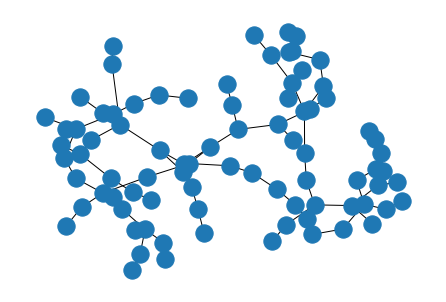

In [4]:
orig_tree = nx.maximum_spanning_tree (graph_dict['NENAH004orig'][graph])
nx.draw(orig_tree)

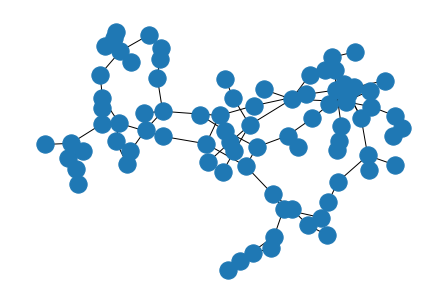

In [5]:
run2_tree = nx.maximum_spanning_tree (graph_dict['NENAH004run2'][graph])


In [10]:
run2_tree.edges()

EdgeView([(0, 13), (0, 28), (1, 50), (1, 24), (1, 21), (2, 22), (2, 25), (3, 19), (4, 14), (4, 40), (5, 7), (6, 9), (6, 27), (7, 13), (8, 23), (8, 21), (8, 14), (10, 17), (10, 33), (11, 19), (11, 14), (12, 24), (12, 35), (12, 30), (14, 39), (15, 21), (15, 22), (16, 18), (16, 33), (20, 29), (20, 22), (22, 37), (23, 27), (24, 73), (26, 75), (28, 29), (28, 32), (31, 33), (33, 37), (34, 83), (34, 35), (35, 36), (36, 41), (37, 38), (42, 43), (42, 46), (43, 45), (43, 44), (44, 71), (44, 82), (44, 48), (46, 63), (47, 80), (49, 62), (50, 70), (50, 75), (51, 71), (51, 74), (52, 68), (53, 63), (54, 58), (54, 60), (55, 62), (55, 78), (55, 76), (56, 62), (57, 72), (57, 70), (58, 76), (59, 82), (59, 66), (60, 68), (61, 73), (61, 79), (62, 77), (64, 70), (65, 67), (65, 82), (69, 71), (69, 78), (72, 76), (77, 81), (80, 82)])

In [11]:
orig_tree.edges()

EdgeView([(0, 13), (0, 28), (1, 50), (1, 24), (1, 21), (2, 22), (2, 25), (3, 19), (4, 14), (4, 40), (5, 7), (6, 9), (6, 27), (7, 13), (8, 23), (8, 21), (10, 17), (10, 33), (11, 19), (11, 14), (12, 24), (12, 35), (12, 30), (14, 39), (15, 21), (15, 22), (16, 18), (16, 33), (20, 29), (20, 22), (22, 37), (23, 27), (24, 73), (26, 75), (28, 29), (28, 32), (31, 33), (33, 37), (34, 83), (34, 35), (35, 36), (35, 39), (36, 41), (37, 38), (42, 43), (42, 46), (43, 45), (43, 44), (44, 71), (44, 82), (44, 48), (46, 63), (47, 80), (49, 62), (50, 70), (50, 75), (51, 71), (51, 74), (52, 68), (53, 63), (54, 58), (54, 60), (55, 62), (55, 78), (55, 76), (56, 62), (57, 72), (57, 70), (58, 76), (59, 82), (59, 66), (60, 68), (61, 73), (61, 79), (62, 77), (64, 70), (65, 67), (65, 82), (69, 71), (69, 78), (72, 76), (77, 81), (80, 82)])

In [ ]:
NENAH004 maximum spanning tree differences

orig (35,39)
run2 (8,14)

In [12]:
orig_tree_df = nx.to_pandas_adjacency(orig_tree)
run_2_df = nx.to_pandas_adjacency(run2_tree)
orig_tree_df.head(84)

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.312138,0.0
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.113871,0.0,0.0,0.000000,0.0,0.000000,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.312138,0.0,0.000000,0.0
